# <font color=salmon>PART 1 - RAPPEL DU CONTEXTE PROJET</font>

# <font color=salmon>PARTIE 1 - RAPPEL DU PROJET DE CONTEXTE</font>

# <font color=salmon>PART 1 - REMINDER</font>

## **<font color=green>The project</font>**

Our project consists of **designing, training and deploying an image segmentation model**, which will easily integrate into the complete chain of the on-board system of an autonomous car:
1. real-time image acquisition;
2. image processing;
3. <font color=blue>**image segmentation**</font>;
4. and finally, the decision system.

## **<font color=green>Dataset</font>**

We will work with the [Cityscapes](https://www.cityscapes-dataset.com/dataset-overview/) dataset:
- 2380 annotated images and masks in the Train Set;
- 595 annotated images and masks in the Validation Set;
- 500 annotated images and masks in the Test Set.

# <font color=salmon>PART 2 - LIBRARIES, PARAMETERS, HELPERS</font>

## **<font color=green>Loading libraries</font>**

In [2]:
import pandas as pd
import numpy as np
import os, glob
import random
from time import time
import tqdm
import six
from collections import namedtuple

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from imgaug import augmenters as iaa

print("Tensorflow version " + tf.__version__)
print("OpenCV " + cv2.__version__)

Tensorflow version 2.7.0
OpenCV 4.1.2


## **<font color=green>Loading data</font>**

In [3]:
# Set all paths to folders: project, model, images, masks
project_path = '/content/drive/MyDrive/OC_IA/P08'
model_path = '/content/drive/MyDrive/OC_IA/P08/model'
checkpoint_path = '/content/drive/MyDrive/OC_IA/P08/checkpoints'
train_input_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/train/images'
train_mask_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/train/masks30'
train_target_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/train/masks'
val_input_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/val/images'
val_mask_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/val/masks30'
val_target_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/val/masks'
test_input_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/test/images'
test_mask_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/test/masks30'
test_target_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/test/masks'

In [5]:
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_mask_path = sorted(glob.glob(train_mask_dir +'/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(train_input_path), 
      ' - Number of original masks: ', len(train_mask_path),
      ' - Number of target (8 categories): ', len(train_target_path))
print(train_input_path[0] + '\n')

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_mask_path = sorted(glob.glob(val_mask_dir +'/*.png'))
val_target_path = sorted(glob.glob(val_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(val_input_path), 
      ' - Number of original masks: ', len(val_mask_path),
      ' - Number of target (8 categories): ', len(val_target_path))
print(val_input_path[0] + '\n')

test_input_path = sorted(glob.glob(test_input_dir + '/*.png'))
test_mask_path = sorted(glob.glob(test_mask_dir +'/*.png'))
test_target_path = sorted(glob.glob(test_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(test_input_path), 
      ' - Number of original masks: ', len(test_mask_path),
      ' - Number of target (8 categories): ', len(test_target_path))
print(test_input_path[0])

TRAIN -- Number of images:  2380  - Number of original masks:  2380  - Number of target (8 categories):  2380
/content/drive/MyDrive/OC_IA/P08/dataset/train/images/aachen_000000_000019.png

TRAIN -- Number of images:  595  - Number of original masks:  595  - Number of target (8 categories):  595
/content/drive/MyDrive/OC_IA/P08/dataset/val/images/stuttgart_000104_000019.png

TRAIN -- Number of images:  500  - Number of original masks:  500  - Number of target (8 categories):  500
/content/drive/MyDrive/OC_IA/P08/dataset/test/images/frankfurt_000000_000294.png


In [6]:
from IPython.display import clear_output
!pip install --upgrade git+https://github.com/zatafa/image-segmentation-keras.git
clear_output()

from keras_segmentation.models.fcn import fcn_8_mobilenet
from keras_segmentation.models.unet import vgg_unet
from keras_segmentation.models.segnet import mobilenet_segnet

## **<font color=green>Template Parameters</font>**

In [7]:
# Set parameters & hyperparameters
img_height, img_width = 256, 512
img_size = (img_height, img_width)
batch_size = 16
n_classes = 8
samples = len(train_input_path)
optimizer = 'adam'
loss='categorical_crossentropy'
score_IoU = tf.keras.metrics.MeanIoU(num_classes=8,
                                     name='mean_IoU')
epochs = 10
epochs_optim = 3

### **<font color=blue>Dataframe save results</font>**

In [ ]:
# Append model's result to dataframe
def model_result_to_dataframe(model_name, epochs, training_time, eval_time, 
                              df_result, model_result, do_augment=False):

    if do_augment==True:
        model_name = (f'augmented_{model_name}')

    df_result =df_result.append(
        {'model':model_name,
         'epoch': epochs,
         'training_time':training_time,
         'eval_time':eval_time,
         'freq_weighted_IoU':model_result["frequency_weighted_IU"],
         'mean_IoU':model_result["mean_IU"],
         'void_IoU':model_result["class_wise_IU"][0],
         'flat_IoU':model_result["class_wise_IU"][1],
         'construction_IoU':model_result["class_wise_IU"][2],
         'object_IoU':model_result["class_wise_IU"][3],
         'nature_IoU':model_result["class_wise_IU"][4],
         'sky_IoU':model_result["class_wise_IU"][5],
         'human_IoU':model_result["class_wise_IU"][6],
         'vehicule_IoU':model_result["class_wise_IU"][7]},
         ignore_index=True)
    
    return df_result

### **<font color=blue>Viewing predictions</font>**

In [21]:
# Function to resize image
def resize_dataset(pred, img_width, img_height):
    img = pred
    # Use interpolation inter_nearest to use integer with cv2
    resized_img = cv2.resize(img, dsize=(img_width, img_height),
                             interpolation=cv2.INTER_NEAREST)
    return resized_img

# Function to plot original images and masks VS. predicted masks
def plot_image_mask_prediction(test_input_path, test_target_path, 
                               img_height, img_width, random=True, n=5):
    
    if random:
        # Generate random images/masks of n-number
        ids = np.random.choice(np.arange(len(test_input_path)), size=n)
        print(ids)
    
    else:
        ids = [498, 175]
    
    # Plot
    for i in ids:
        image = img_to_array(load_img(f'{test_input_path[i]}'))/255.
        mask = img_to_array(load_img(f'{test_target_path[i]}',
                                     color_mode = "grayscale"))
        mask = np.squeeze(mask)
        pred = model.predict_segmentation(inp=test_input_path[i])
        pred= resize_dataset(pred, img_width, img_height)
        
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(1, 3, 1)
        ax.set_title('Image')
        ax.imshow(image)
        
        ax1 = fig.add_subplot(1, 3, 2)
        ax1.set_title('True mask')
        ax1.imshow(mask, cmap='nipy_spectral_r' )
        
        ax2 = fig.add_subplot(1, 3, 3)
        ax2.set_title('predicted_Mask')
        ax2.imshow(pred, cmap='nipy_spectral_r')

# <font color=salmon>PART 3 - APPLYING DATA AUGMENT</font> 

## **<font color=green>Data Augmentation Pipeline</font>**

In [8]:
def custom_augmentation():
    """ Enlarge the dataset and expose the model
        to different cases
    """
    return  iaa.Sequential(
        [iaa.Fliplr(0.3),
         iaa.GaussianBlur(sigma=(0, 3.0)),
         iaa.Rain(speed=(0.1, 0.3)),
         iaa.Snowflakes(flake_size=(0.7, 0.95), 
                        speed=(0.001, 0.03))])

## **<font color=green>Call template</font>**

In [9]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

17235968/17225924 [==============================] - 0s 0us/step


In [10]:
# Check model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 512, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 258, 514, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 128, 256, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 256, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 128, 256, 32)      0         
                                                                 
 conv_pad_1 (ZeroPadding2D)  (None, 130, 258, 32)      0         
                                                           

## **<font color=green>Train the model</font>**

In [ ]:
print(f'Training for augmented_{model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=None,
            do_augment=True,
            custom_augmentation=custom_augmentation,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/augmented_{model_name}.h5')

## **<font color=green>Evaluate template</font>**

In [ ]:
# Reload result dataframe if necessary
# df_result = pd.read_csv(project_path +'/p8_bench_models.csv')

# Evaluate the model
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

500it [22:54,  2.75s/it]

Evaluation time : 1375.042861700058


In [ ]:
# Display all results associated to the current model
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=True)
# Save to CSV
df_result.to_csv(project_path +'/p8_bench_models.csv', index=False)

# Display result
df_result

,model,epoch,training_time,eval_time,freq_weighted_IoU,mean_IoU,void_IoU,flat_IoU,construction_IoU,object_IoU,nature_IoU,sky_IoU,human_IoU,vehicule_IoU
0,augmented_mobilenet_segnet,10,9963.648859,1375.042862,0.790552,0.669942,0.62672,0.894638,0.770774,0.243559,0.79464,0.813515,0.450355,0.765336


## **<font color=green>View predictions</font>**

[327   2 336 398  45]


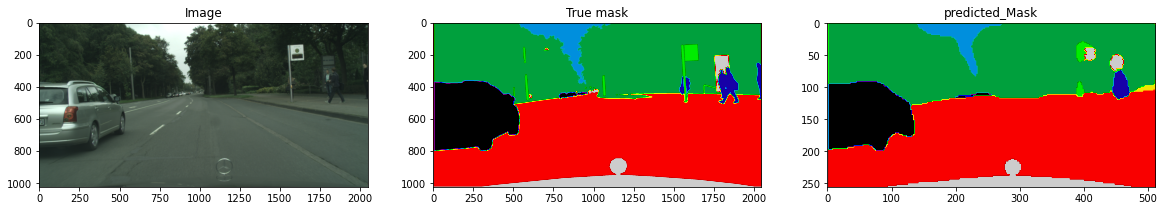

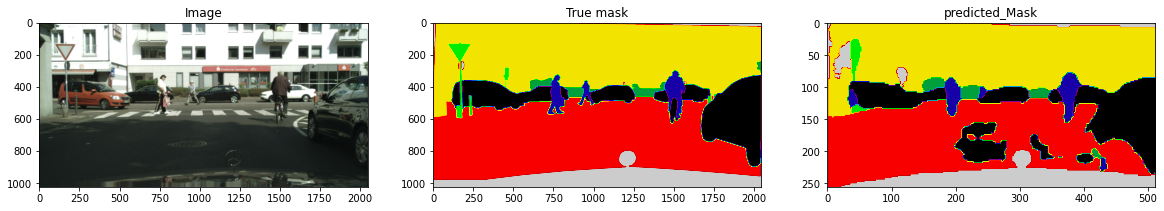

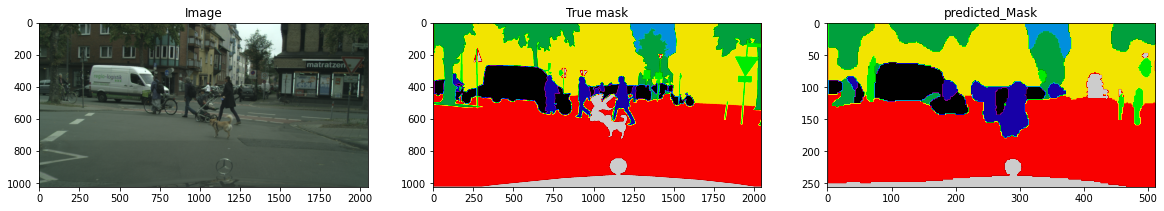

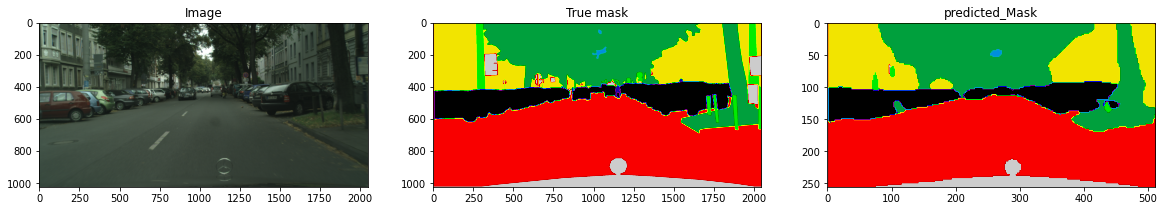

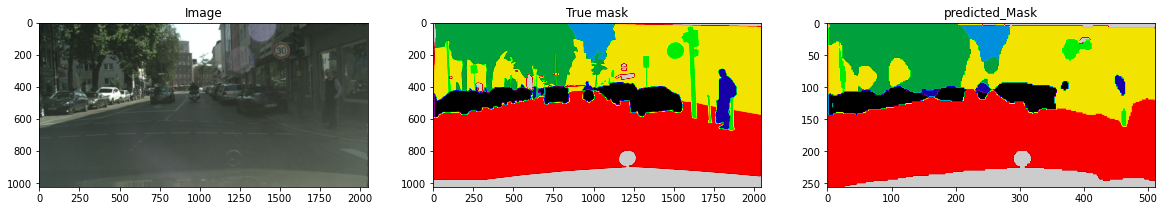

In [ ]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=5)

# <font color=salmon>PART 4 ​​- OPTIMIZATION OF LOSS FUNCTION</font> 

## **<font color=green>Additional loss functions</font>**

In [12]:
# Function for dice loss
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1e-8
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - score

# Function for total loss (dice + cce)
cce = 'categorical_crossentropy'
def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    ttl_loss = cce(y_true, y_pred).numpy() + (3*dice_loss(y_true, y_pred))
    return ttl_loss

## **<font color=green>Save data in a dataframe</font>**

In [18]:
# Prepare dataframe to save results
df_loss = pd.DataFrame(columns= ['model_name', 'freq_weighted_IoU', 'mean_IoU'])

# Save to CSV
df_loss.to_csv(project_path +'/p8_bench_loss.csv', index=False)

## **<font color=green>Train the model with Categorical CrossEntropy</font>**

### **<font color=blue>Call template</font>**

In [14]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

### **<font color=blue>Train the model</font>**

In [15]:
print(f'Training for optimized_{model_name} with Categorical Cross-Entropy')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}_diceLoss.h5', 
                             save_best_only=True)]

# Train the model
model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs_optim,
            loss=None,
            callbacks=callbacks,
            display_history=False)

Training for optimized_mobilenet_segnet with Categorical Cross-Entropy
Verifying training dataset


100%|██████████| 2380/2380 [03:06<00:00, 12.75it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [00:46<00:00, 12.72it/s]


Dataset verified! 
Epoch 1/3
512/512 [==============================] - 799s 2s/step - loss: 0.3336 - score_IoU: 0.4375 - accuracy: 0.8914 - val_loss: 0.3477 - val_score_IoU: 0.4377 - val_accuracy: 0.8934
Epoch 2/3
512/512 [==============================] - 819s 2s/step - loss: 0.2143 - score_IoU: 0.4384 - accuracy: 0.9252 - val_loss: 0.3580 - val_score_IoU: 0.4384 - val_accuracy: 0.8825
Epoch 3/3
512/512 [==============================] - 831s 2s/step - loss: 0.1784 - score_IoU: 0.4416 - accuracy: 0.9364 - val_loss: 0.3835 - val_score_IoU: 0.4476 - val_accuracy: 0.9094


### **<font color=blue>Evaluate template</font>**

In [19]:
# Evaluate the model
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)

model_name = (f'{model_name}_cce')

# Display all results associated to the current model
df_loss = df_loss.append({'model_name':model_name,
                          'freq_weighted_IoU':model_result["frequency_weighted_IU"],
                          'mean_IoU':model_result["mean_IU"]},
                          ignore_index=True)

# Save to CSV
df_loss.to_csv(project_path +'/p8_bench_loss.csv', index=False)

# Display result
df_loss

,model_name,freq_weighted_IoU,mean_IoU
0,mobilenet_segnet_cce_cce,0.812136,0.692774


### **<font color=blue>View predictions</font>**

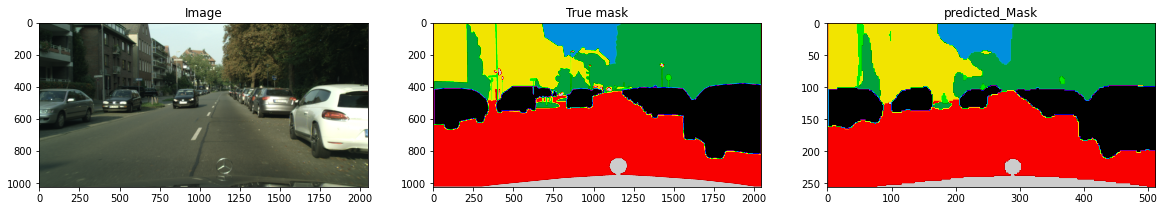

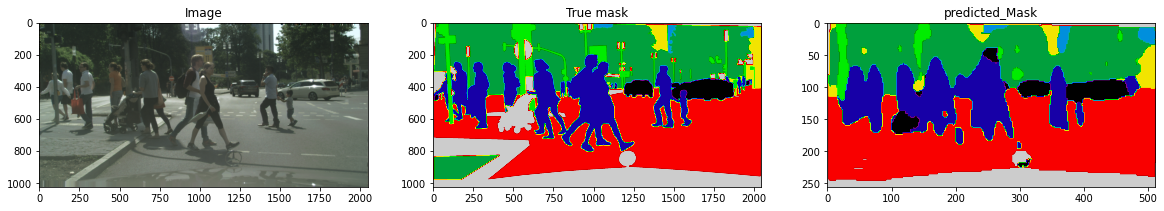

In [22]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=False, n=2)

## **<font color=green>Train the model with Dice Loss</font>**

### **<font color=blue>Call template</font>**

In [23]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

### **<font color=blue>Train the model</font>**

In [24]:
print(f'Training for optimized_{model_name} with Dice Loss')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}_diceLoss.h5', 
                             save_best_only=True)]

# Train the model
model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs_optim,
            loss=dice_loss,
            callbacks=callbacks,
            display_history=False)

Training for optimized_mobilenet_segnet with Dice Loss
Verifying training dataset


100%|██████████| 2380/2380 [03:22<00:00, 11.75it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [00:49<00:00, 12.03it/s]


Dataset verified! 
Epoch 1/3
512/512 [==============================] - 804s 2s/step - loss: 0.1156 - score_IoU: 0.5763 - accuracy: 0.8866 - val_loss: 0.1093 - val_score_IoU: 0.6899 - val_accuracy: 0.8917
Epoch 2/3
512/512 [==============================] - 775s 2s/step - loss: 0.0872 - score_IoU: 0.7357 - accuracy: 0.9134 - val_loss: 0.0910 - val_score_IoU: 0.8226 - val_accuracy: 0.9095
Epoch 3/3
512/512 [==============================] - 777s 2s/step - loss: 0.0778 - score_IoU: 0.8220 - accuracy: 0.9226 - val_loss: 0.0901 - val_score_IoU: 0.8461 - val_accuracy: 0.9104


### **<font color=blue>Evaluate template</font>**

In [25]:
# Evaluate the model
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)

model_name = (f'{model_name}_diceLoss')

# Display all results associated to the current model
df_loss = df_loss.append({'model_name':model_name,
                          'freq_weighted_IoU':model_result["frequency_weighted_IU"],
                          'mean_IoU':model_result["mean_IU"]},
                          ignore_index=True)

# Save to CSV
df_loss.to_csv(project_path +'/p8_bench_loss.csv', index=False)

# Display result
df_loss

500it [01:26,  5.79it/s]


,model_name,freq_weighted_IoU,mean_IoU
0,mobilenet_segnet_cce_cce,0.812136,0.692774
1,mobilenet_segnet_diceLoss,0.808124,0.659275


### **<font color=blue>View predictions</font>**

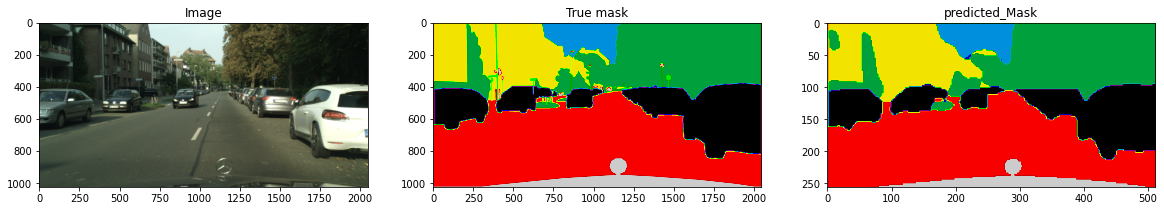

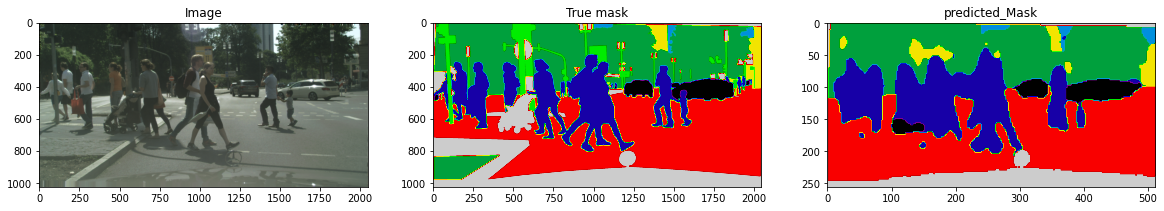

In [26]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=False, n=2)

## **<font color=green>Train the model with Total Loss</font>**

### **<font color=blue>Call template</font>**

In [27]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

### **<font color=blue>Train the model</font>**

In [28]:
print(f'Training for optimized_{model_name} with Total Loss (CCE + DiceLosse')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}_ttlLoss.h5', 
                             save_best_only=True)]

# Train the model
model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs_optim,
            loss=dice_loss,
            callbacks=callbacks,
            display_history=False)

Training for optimized_mobilenet_segnet with Total Loss (CCE + DiceLosse
Verifying training dataset


100%|██████████| 2380/2380 [03:28<00:00, 11.43it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [00:50<00:00, 11.80it/s]


Dataset verified! 
Epoch 1/3
512/512 [==============================] - 836s 2s/step - loss: 0.1157 - score_IoU: 0.6052 - accuracy: 0.8869 - val_loss: 0.1029 - val_score_IoU: 0.6767 - val_accuracy: 0.8981
Epoch 2/3
512/512 [==============================] - 827s 2s/step - loss: 0.0911 - score_IoU: 0.7072 - accuracy: 0.9095 - val_loss: 0.1236 - val_score_IoU: 0.8084 - val_accuracy: 0.8774
Epoch 3/3
512/512 [==============================] - 824s 2s/step - loss: 0.0844 - score_IoU: 0.7869 - accuracy: 0.9160 - val_loss: 0.0989 - val_score_IoU: 0.8232 - val_accuracy: 0.9013


### **<font color=blue>Evaluate template</font>**

In [29]:
# Evaluate the model
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)

model_name = (f'{model_name}_ttlLoss')

# Display all results associated to the current model
df_loss = df_loss.append({'model_name':model_name,
                          'freq_weighted_IoU':model_result["frequency_weighted_IU"],
                          'mean_IoU':model_result["mean_IU"]},
                          ignore_index=True)

# Save to CSV
df_loss.to_csv(project_path +'/p8_bench_loss.csv', index=False)

# Display result
df_loss

500it [01:23,  5.99it/s]


,model_name,freq_weighted_IoU,mean_IoU
0,mobilenet_segnet_cce_cce,0.812136,0.692774
1,mobilenet_segnet_diceLoss,0.808124,0.659275
2,mobilenet_segnet_ttlLoss,0.797208,0.598140


### **<font color=blue>View predictions</font>**

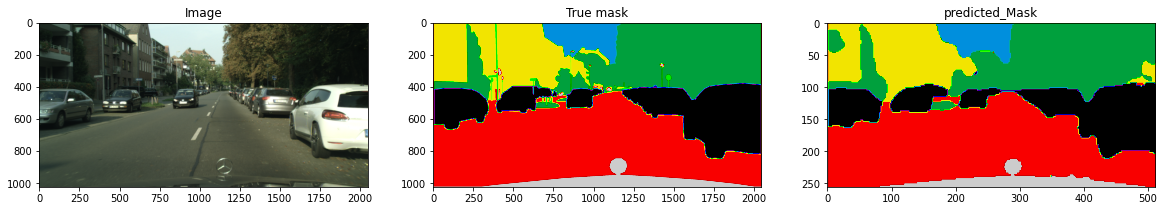

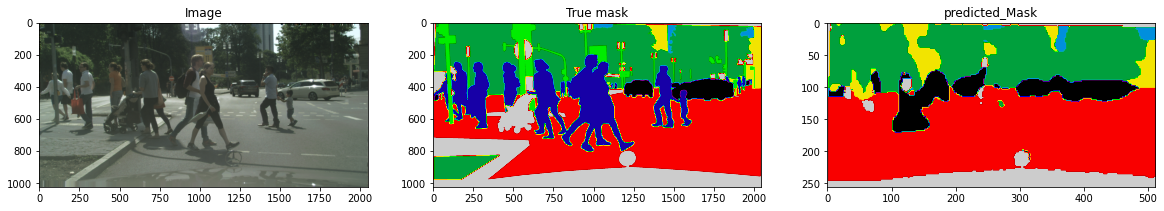

In [30]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=False, n=2)

### **<font color=blue>Conclusion on loss functions</font>**

After optimization, it turns out that the loss functions **Dice Loss** and the combination of **Categorical Cross-Entropy and Dice Loss as Total Loss** does not improve not the performance of the model.

We therefore keep the loss function: <font color=green>**Categorical Cross-Entropy**</font>, which seems to be very well adapted to our data.